# Simple gene regulatory networks

In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la
import ladynamic as lad

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import networkx as nx

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/7928004d58943529a7be774575a62ca436a82a7f)

In [60]:
genes = la.Dim(5, "gene")
proteins = la.Dim(range(len(genes)), "protein")

In [61]:
mrna_initial = la.Fixed(1.)
protein_initial = la.Fixed(0.)
transcription_maximal = la.Fixed(np.array([0., 10., 20., 30., 40.]), definition = la.Definition([genes]))
degradation = la.Fixed(np.array([1., 1., 1., 1., 1.]), definition = la.Definition([genes]))

In [62]:
mrna = lad.State(mrna_initial, definition = la.Definition([genes]), label = "mrna")
protein = lad.State(mrna_initial, definition = la.Definition([genes]), label = "protein")

In [63]:
class dmrna(la.Computed):
    transcription_maximal = la.variables.VariablePromise("transcription_maximal", r"\textit{transcription}_{max}")
    degradation = la.variables.VariablePromise("degradation")
    mrna = la.variables.VariablePromise("mrna")
    def __call__(self, transcription_maximal, degradation, mrna):
        return transcription_maximal - degradation * mrna
    
class dprotein(la.Computed):
    mrna = la.variables.VariablePromise(dims = la.variables.promise.ParentSwitched("transcript_dim", "protein_dim"))
    protein = la.variables.VariablePromise(dims = la.variables.promise.ParentSwitched("protein_dim", "transcript_dim"))
    
    def __init__(self, mrna, protein, *args, definition = None ,**kwargs):
        self.transcript_dim = mrna[-1]
        self.protein_dim = protein[-1]
        
        definition = mrna.clean.contract(mrna[-1]).expand_right(protein[-1])
        super().__init__(*args, definition = definition, **kwargs)
        
    def __call__(self, mrna, protein):
        return protein - mrna

In [64]:
mrna.derivative = dmrna(transcription_maximal, degradation, mrna)
protein.derivative = dprotein(mrna, protein)


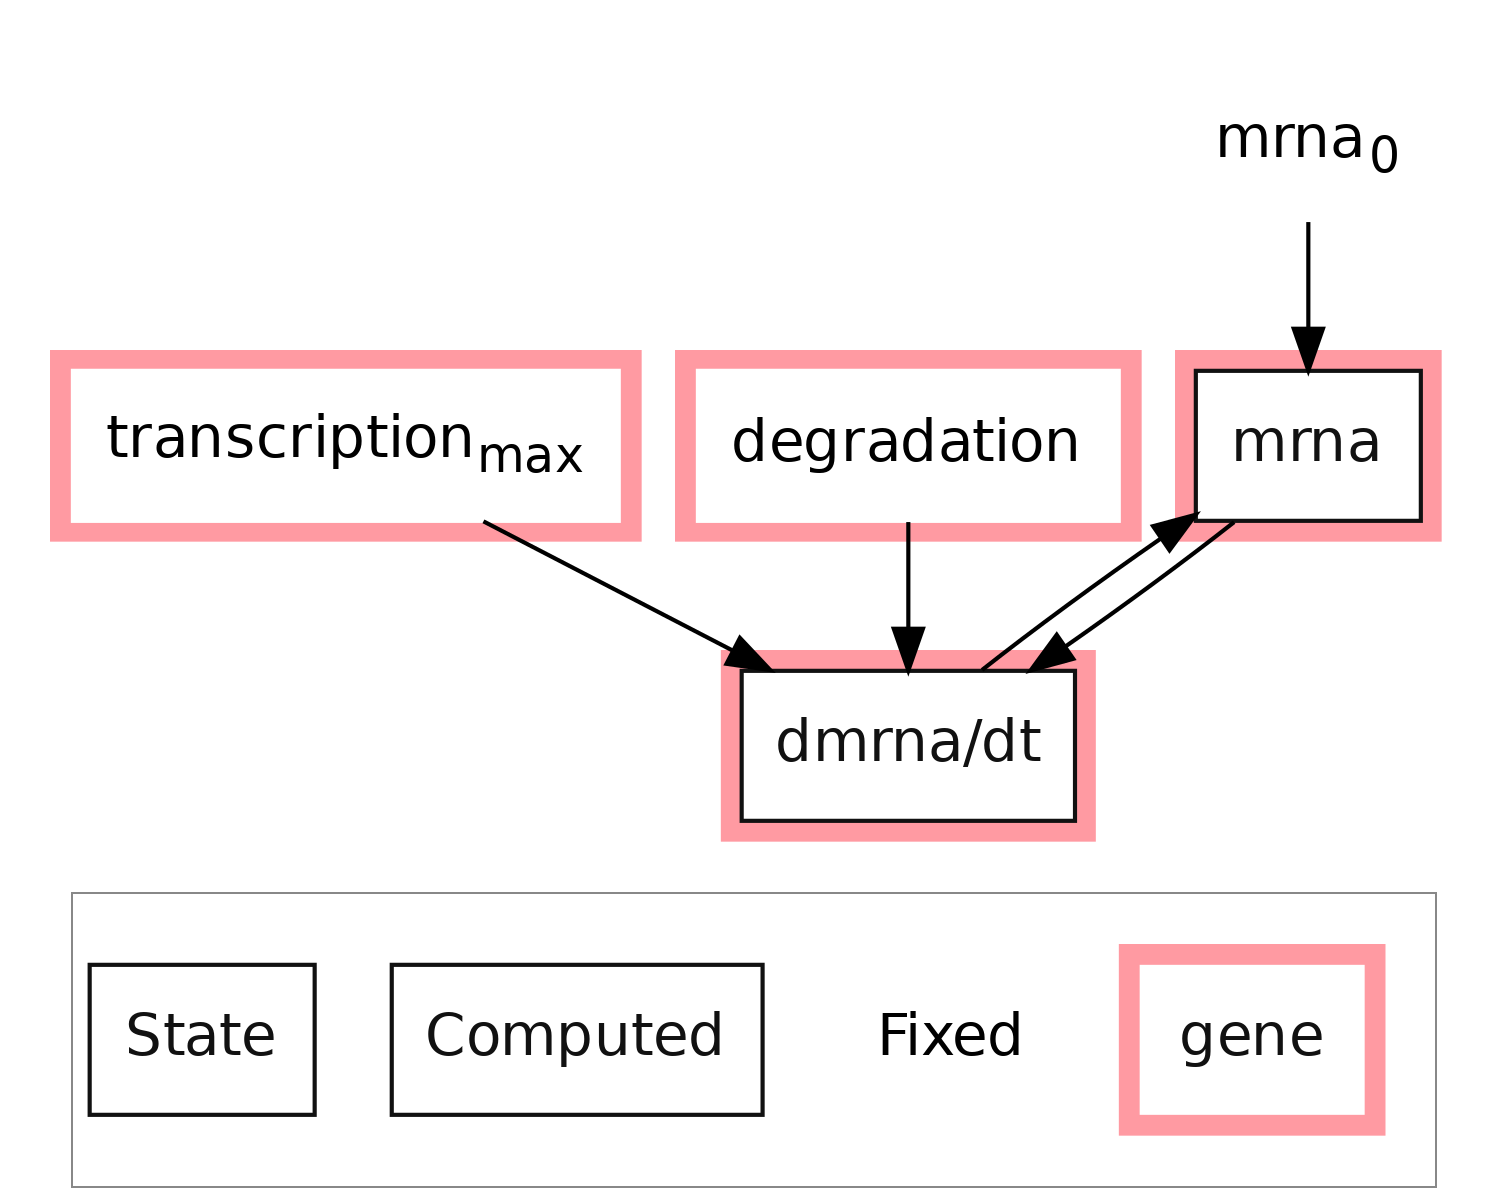

In [65]:
mrna.plot()

In [66]:
dt = la.Fixed(0.01)
final_time = la.Fixed(10.)
delta_time = la.Fixed(1.)
mrna_extractor = lad.extractors.DeltaExtractor(mrna, final_time, delta_time)

extractors = [mrna_extractor]

In [67]:
states = [mrna]
dynamics = lad.solvers.Euler(states, extractors, dt)

In [68]:
time = dynamics.time
time_extractor = lad.extractors.DeltaExtractor(time, final_time, delta_time)
dynamics.add_extractors(time_extractor)

In [69]:
dispersion = la.Fixed(0.01)
counts = la.distributions.NegativeBinomial2(mrna_extractor, dispersion)


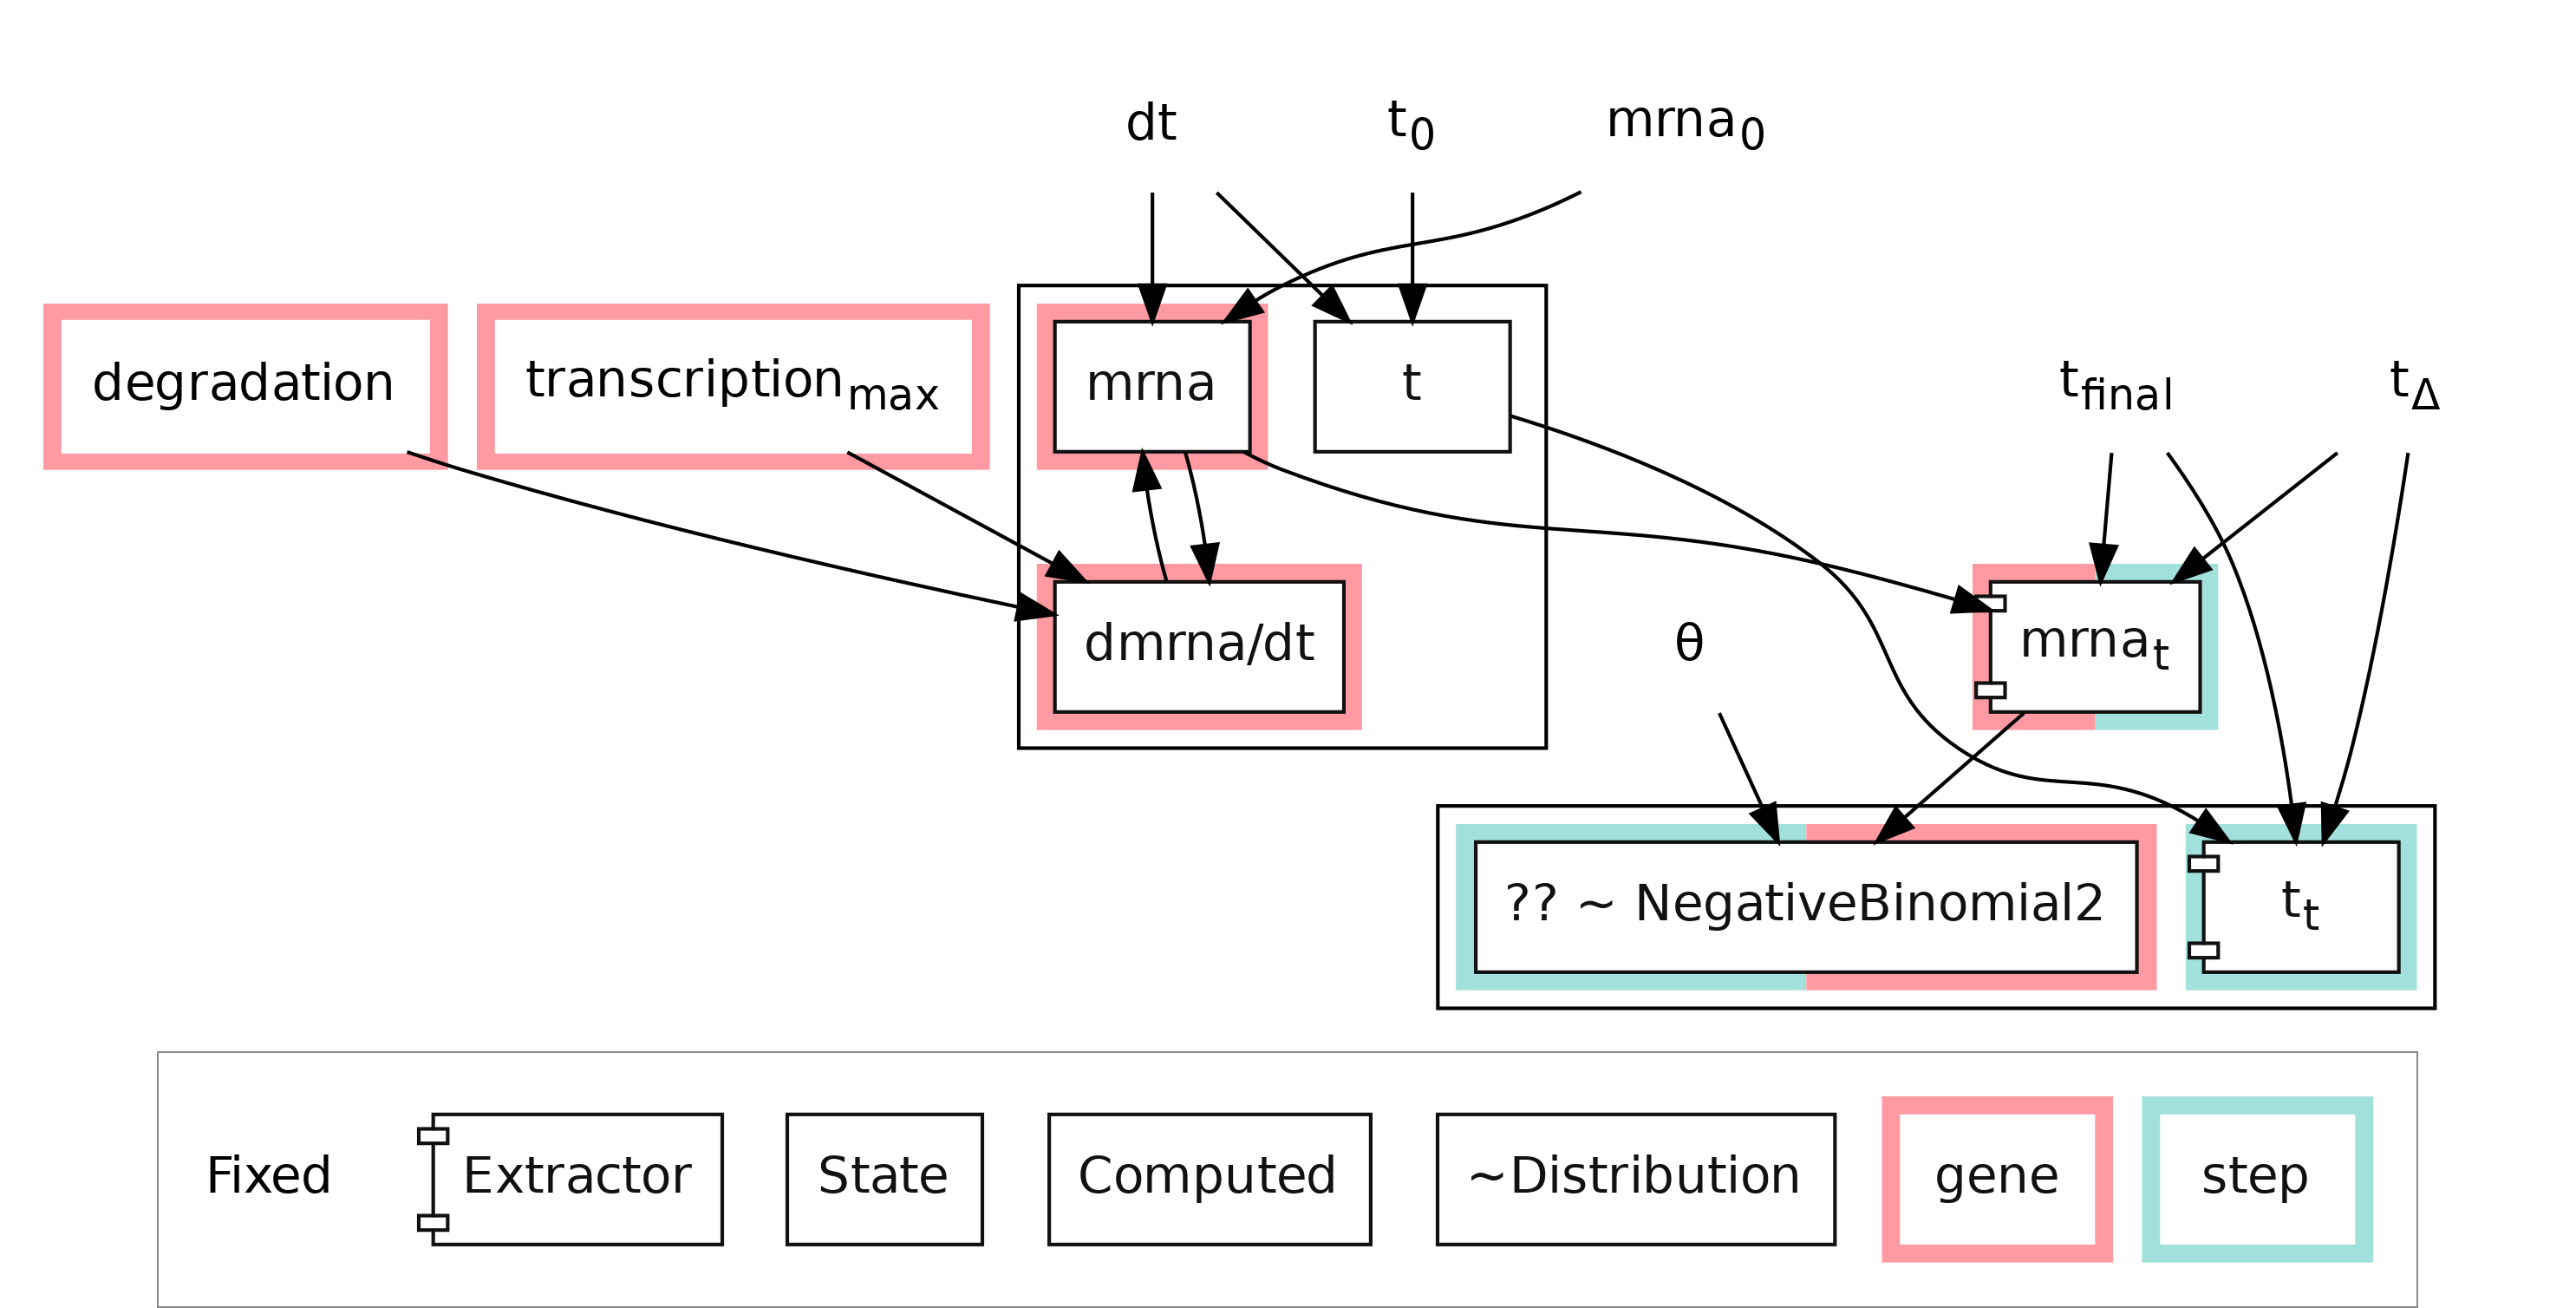

In [70]:
model = la.Model(counts = counts, time = time_extractor)
model.plot()

In [71]:
posterior = la.posterior.Posterior(model, batch_dim = "")
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [75]:
time_values = posterior.samples[time_extractor].sel(sample = 0).broadcast_like(posterior.samples[mrna_extractor].sel(sample = 0))
steps = xr.concat([
    posterior.samples[counts].sel(sample = 0),
    posterior.samples[counts.mu].sel(sample = 0),
    time_values
], dim = pd.Series(["counts", "expression", "time"], name = "state"))

In [76]:
sns.set_palette("Set1", 8, .75)

In [77]:
import matplotlib as mpl

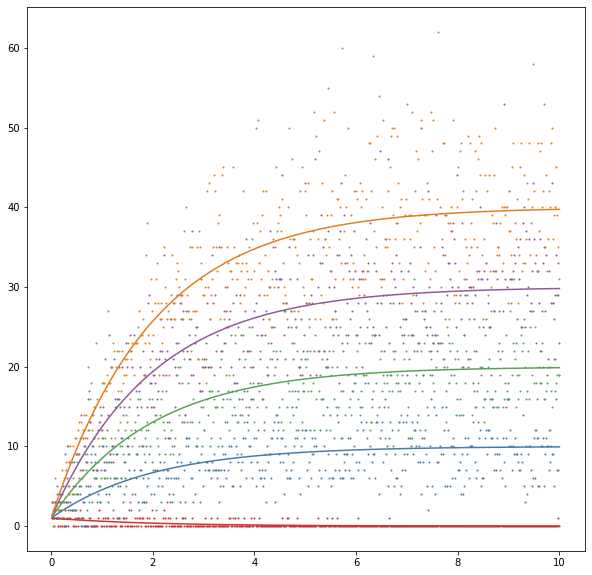

In [81]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
for gene_id in genes.index:
    plotdata = steps.sel(gene = gene_id).to_pandas().T
    ax.scatter(plotdata["time"], plotdata["counts"], s = 1)
    ax.plot(plotdata["time"], plotdata["expression"])

In [82]:
last_step = posterior.samples[counts].coords["step"][-1]
counts_value = posterior.samples[counts].sel(step = last_step).to_pandas()

In [83]:
counts_value.index = pd.Series(counts_value.index, name = "cell")

## Optimizing dynamic parameters

In [84]:
mrna_initial = la.Fixed(1.)
# transcription_maximal = la.Parameter(10., definition = la.Definition([genes]), transforms=[la.transforms.Exp()])
transcription_maximal = la.Latent(la.distributions.LogNormal(), definition = la.Definition([genes]))
# transcription_maximal = la.Fixed(10., definition = la.Definition([genes]), transforms=[la.transforms.Exp()])
degradation = la.Fixed(np.array([1., 1., 1., 1., 1.]), definition = la.Definition([genes]))

In [85]:
mrna = lad.State(mrna_initial, definition = la.Definition([genes]), label = "mrna")

In [86]:
mrna.derivative = dmrna(transcription_maximal, degradation, mrna)

In [87]:
mrna_extractor = lad.extractors.FinalExtractor(mrna, final_time)

extractors = [mrna_extractor]

In [88]:
states = [mrna]
dynamics = lad.solvers.Euler(states, extractors, dt)

In [89]:
counts_p = la.distributions.NegativeBinomial2(mrna_extractor, dispersion, definition = la.Definition.from_xr(counts_value))

In [90]:
counts = la.Observation(counts_value, counts_p, label = "counts")


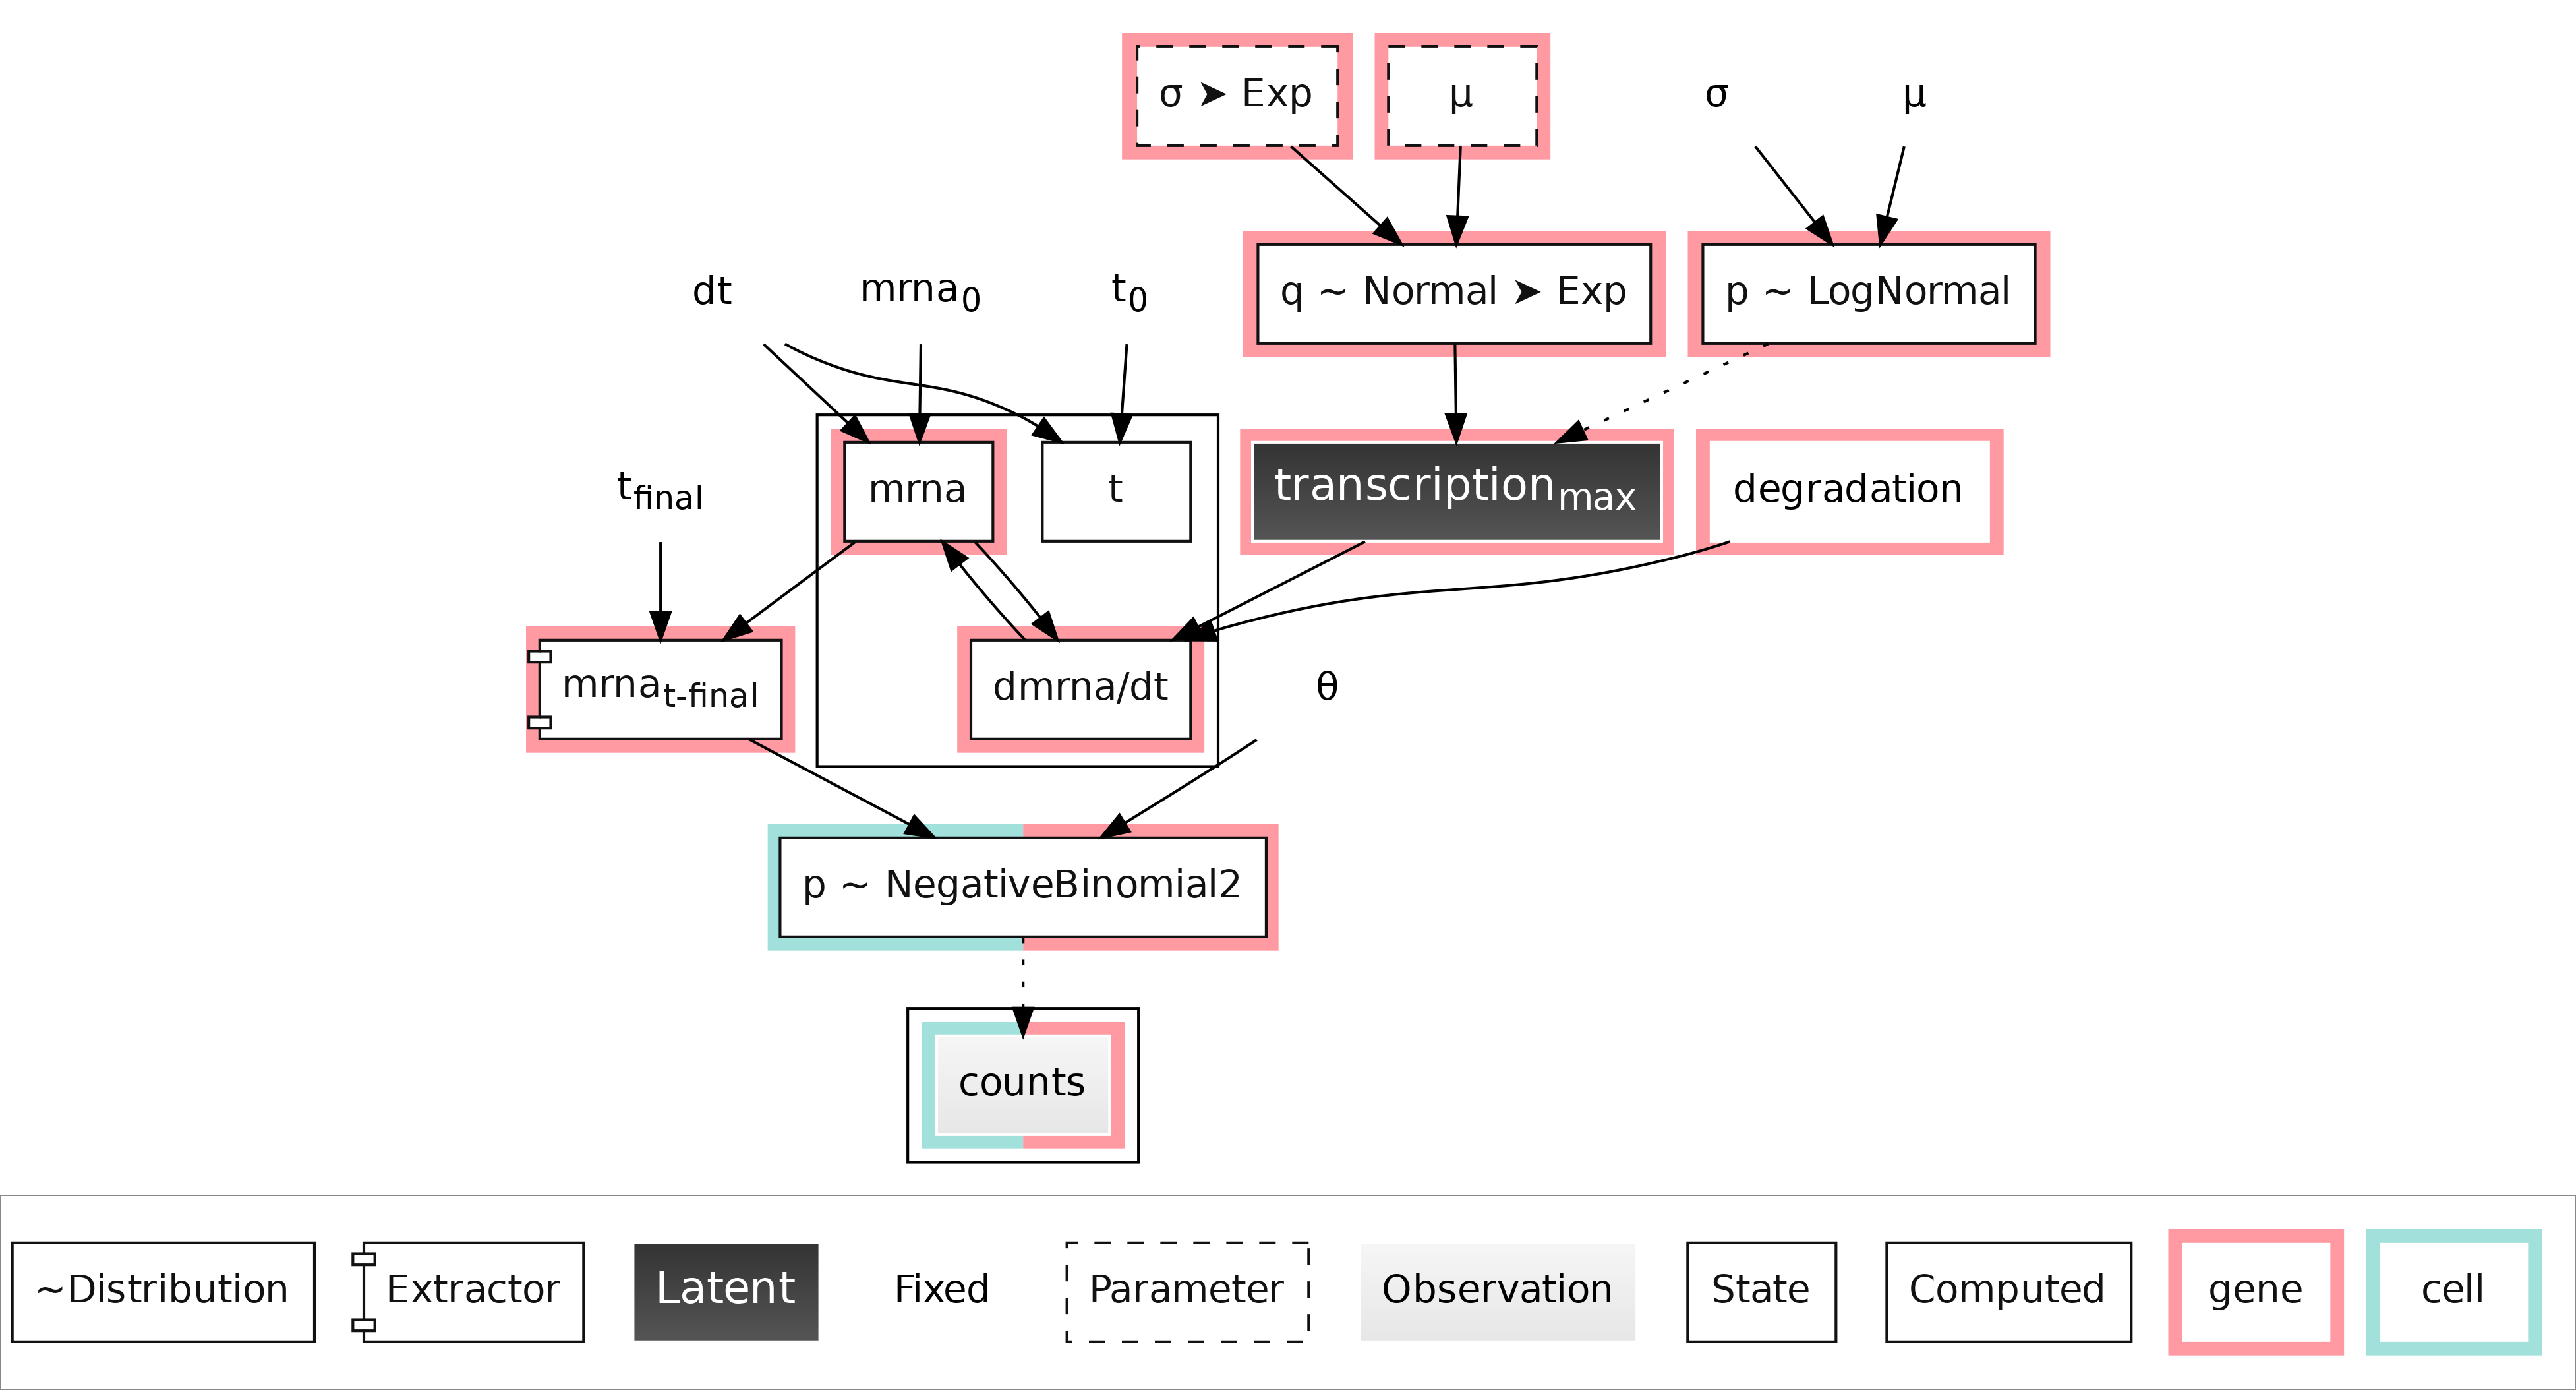

In [91]:
model = la.Model(counts)
model.plot()

  0%|                                                                                                         …

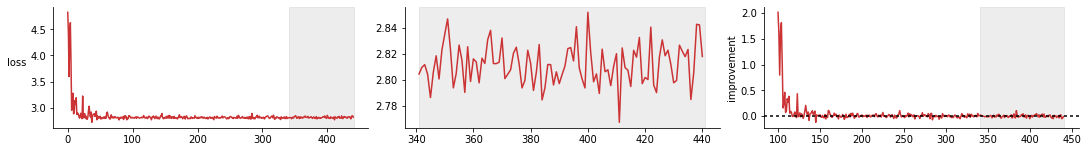

In [95]:
inference = la.infer.svi.SVI(model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr = 0.05))
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(1000)
trace.plot();

In [96]:
posterior = la.posterior.Posterior(model)
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]